In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [59]:
!wget https://www.dropbox.com/s/bw7vcwdse226vr4/data.csv
df = pd.read_csv('data/data.csv',sep=';')

X:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#удаляем лишние пробелы из названия колонок

df.columns = df.columns.str.replace(' ', '')

ОПРЕДЕЛЯЕМ ОСНОВНЫЕ ДАТЧИКИ, КОТОРЫЕ ПОДВЕРГАЮТСЯ АТАКАМ

In [5]:
#Чтение файла

df2 = pd.read_excel('data/List_of_attacks_Final.xlsx')
df2 = df2.drop(df2[df2['Attack Point'].isna() == True].index)

In [6]:
#Удаляем строки No Physical Impact Attack

df2 = df2.drop(df2[df2['Attack Point'] == 'No Physical Impact Attack'].index)

In [7]:
#Получаем список уникальных значений из колонки Attack Point

print("количество датчиков, которые подвергаются атакам", len(df2['Attack Point'].unique()))
print()
print("Список датчиков")
print(df2['Attack Point'].unique())

количество датчиков, которые подвергаются атакам 28

Список датчиков
['MV-101' 'P-102' 'LIT-101' 'MV-504' 'AIT-202' 'LIT-301' 'DPIT-301'
 'FIT-401' 'MV-304' 'Mv-303' 'MV-303' 'AIT-504' 'MV-101, LIT-101'
 'UV-401, AIT-502, P-501' 'P-602, DIT-301, MV-302' 'P-203, P-205'
 'LIT-401, P-401' 'P-101, LIT-301' 'P-302, LIT-401' 'P-302'
 'P-201, P-203, P-205' 'LIT-101, P-101, MV-201' 'LIT-401' 'P-101'
 'P-101; P-102' 'P-501, FIT-502' 'AIT-402, AIT-502' 'FIT-401, AIT-502']


In [8]:
#Сплитим значения по пробелу и добавляем в новый чистый список

features = []

for col in df2['Attack Point'].unique():
    features += col.split(', ')

#уберем символ "-" из названия фичей и сделаем все буквы заглавными

for i in range(len(features)):
    features[i] = features[i].replace('-', "")
    features[i] = features[i].upper()
    
features = list(set(features))

In [9]:
#удалим фичи которых нет в тренировочном наборе данных

for i in features:
    if i not in df.columns:
        features.remove(i)

In [10]:
#создадим новый датафрейм в котором будут только фичи из списка features

df_new = pd.DataFrame()

for colname in features:
    df_new[colname] = df[colname].copy()

In [11]:
#Добавим к датасету целевую переменную, чтобы в случае удаления лишних строк, длины тренировочного набора и серия с меткой совпали

df_new['Normal/Attack'] = df['Normal/Attack'].copy()
df_new.head(5)

,P401,MV201,P201,UV401,FIT401,P302,AIT504,DPIT301,P602,LIT401,...,AIT502,P205,MV302,MV101,FIT502,P501,LIT301,P102,AIT402,Normal/Attack
0,1,2,1,2,"1,713517",2,"12,03538","19,74838",1,"942,0662",...,"145,1166",2,2,2,"1,279621",2,"956,1651",1,"156,0882",Normal
1,1,2,1,2,"1,715952",2,"12,03538","19,74838",1,"942,0277",...,"145,1166",2,2,2,"1,297554",2,"956,1651",1,"156,0882",Normal
2,1,2,1,2,"1,715952",2,"12,03538","19,69076",1,"941,8739",...,"145,1166",2,2,2,"1,293967",2,"956,4855",1,"156,0882",Normal
3,1,2,1,2,"1,71467",2,"12,03538","19,69076",1,"941,797",...,"145,0141",2,2,2,"1,281158",2,"956,806",1,"156,0882",Normal
4,1,2,1,2,"1,71467",2,"12,03538","19,69076",1,"942,22",...,"144,8859",2,2,2,"1,281158",2,"957,0864",1,"156,0882",Normal


In [12]:
df_new.columns

Index(['P401', 'MV201', 'P201', 'UV401', 'FIT401', 'P302', 'AIT504', 'DPIT301',
       'P602', 'LIT401', 'MV304', 'P101', 'AIT202', 'LIT101', 'P203', 'MV303',
       'AIT502', 'P205', 'MV302', 'MV101', 'FIT502', 'P501', 'LIT301', 'P102',
       'AIT402', 'Normal/Attack'],
      dtype='object')

In [13]:
#Убираем лишние пробелы из значений целевой переменной

df_new['Normal/Attack'] = df_new['Normal/Attack'].str.replace(' ', "")

In [14]:
unique_values = []

for column in df_new.columns:
    if len(df_new[column].unique()) < 2:
        df_new = df_new.drop(column, axis=1)
        print(column)

P401


In [17]:
df_new

,MV201,P201,UV401,FIT401,P302,AIT504,DPIT301,P602,LIT401,MV304,...,AIT502,P205,MV302,MV101,FIT502,P501,LIT301,P102,AIT402,Normal/Attack
0,2,1,2,"1,713517",2,"12,03538","19,74838",1,"942,0662",1,...,"145,1166",2,2,2,"1,279621",2,"956,1651",1,"156,0882",Normal
1,2,1,2,"1,715952",2,"12,03538","19,74838",1,"942,0277",1,...,"145,1166",2,2,2,"1,297554",2,"956,1651",1,"156,0882",Normal
2,2,1,2,"1,715952",2,"12,03538","19,69076",1,"941,8739",1,...,"145,1166",2,2,2,"1,293967",2,"956,4855",1,"156,0882",Normal
3,2,1,2,"1,71467",2,"12,03538","19,69076",1,"941,797",1,...,"145,0141",2,2,2,"1,281158",2,"956,806",1,"156,0882",Normal
4,2,1,2,"1,71467",2,"12,03538","19,69076",1,"942,22",1,...,"144,8859",2,2,2,"1,281158",2,"957,0864",1,"156,0882",Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2,2,2,"1,705315",2,"14,8039","20,39823",1,"956,8701",1,...,"139,1182",2,2,2,"1,288971",2,"974,5498",1,"145,6037",Normal
449915,2,2,2,"1,705315",2,"14,8039","20,39823",1,"957,1777",1,...,"139,1182",2,2,2,"1,272704",2,"974,5898",1,"145,6037",Normal
449916,2,2,2,"1,706212",2,"14,8039","20,33101",1,"957,293",1,...,"139,1182",2,2,2,"1,269502",2,"974,2695",1,"145,5524",Normal
449917,2,2,2,"1,706212",2,"14,8039","20,29579",1,"957,6775",1,...,"139,1182",2,2,2,"1,263866",2,"974,2294",1,"145,5524",Normal


In [22]:
num_cols = []

for columns in df_new.columns:
    if len(df_new[columns].unique())> 3:
        num_cols += [columns]

In [64]:
for num_col in num_cols:
    df_new[num_col] = df_new[num_col].str.replace(',', '.').astype('float')

In [78]:
df_new.isna().sum()

MV201                0
P201                 0
UV401                0
FIT401           16384
P302                 0
AIT504               0
DPIT301              0
P602                 0
LIT401               0
MV304                0
P101                 0
AIT202               0
LIT101               0
P203                 0
MV303                0
AIT502               0
P205                 0
MV302                0
MV101                0
FIT502               0
P501                 0
LIT301               0
P102                 0
AIT402               0
Normal/Attack        0
dtype: int64

<AxesSubplot:>

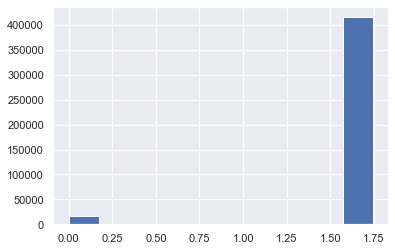

In [80]:
df_new.FIT401.hist()

In [101]:
#Как мы видим, в датасете пропущенные значения присутствуют только в колонке FIT401
#Более того, все строки, которые в колонке FIT401 содержат пропущенное значение, имеют метку Attack

print(len(df_new[df_new.FIT401.isna()]))
print(len(df_new[df_new.FIT401.isna()]['Normal/Attack'] == 'Attack'))

16384
16384


In [116]:
#Построив сводную таблицу, мы видим, что в случае когда FIT401 = 0, в подавляющм числе случаев это признак атаки

pd.pivot_table(df_new[df_new.FIT401 == 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,16374,104


In [119]:
#А в случаях, когда FIT401 больше 0, в большинстве своем наблюдения имеют метку Normal

pd.pivot_table(df_new[df_new.FIT401 > 0], values='FIT401',
                    columns=['Normal/Attack'], aggfunc='count')

Normal/Attack,Attack,Normal
FIT401,21863,395194


In [121]:
#Исходя из вышесказанного, попробем заменить все пропущенные значения FIT401 на 0

df_new['FIT401'] = df_new['FIT401'].fillna(0)

In [122]:
#посчитаем сколько строк с меткой Normal и Attack

print(len(df_new[df_new['Normal/Attack'] == 'Attack']))
print(len(df_new[df_new['Normal/Attack'] == 'Normal']))

54621
395298


In [129]:
#Заменим в нашей целевой переменной метки Normal = 0, Attack = 1

df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Normal', 0)
df_new['Normal/Attack'] = df_new['Normal/Attack'].replace('Attack', 1)

In [130]:
X = df_new.drop('Normal/Attack', axis=1)
y = df_new['Normal/Attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled  = scaler.transform(X_test)

X_train.iloc[:, :] = X_train_scaled
X_test.iloc[:, :] = X_test_scaled

X:\anaconda\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [131]:
#@title Логистическая Регрессия{ run: "auto" }
#@markdown ### Тип Регуляризации 
penalty= 'l1' #@param [ "l2" , "l1", "none"]{type:"string"}
#@markdown ### Константа Регуларизации
regularization = 1.66 #@param {type:"slider", min:0.01, max:3, step:0.05}



LogReg = LogisticRegression(fit_intercept=True,
                            penalty=penalty,solver='saga',
                            C=regularization,
                            max_iter=100000)

LogReg.fit(X_train, y_train)

LogisticRegression(C=1.66, max_iter=100000, penalty='l1', solver='saga')

In [132]:
y_predict=LogReg.predict(X_test)

print('test error')
print('ACC: %.4f' % acc(y_predict,y_test))
print('F1 : %.4f' %  f1(y_predict,y_test,average='binary'))

test error
ACC: 0.9653
F1 : 0.8320
